# **Introduction**

This project focuses on developing a machine learning model to predict the age of abalones using physical measurements.

Typically, determining the age of an abalone involves cutting through the shell and counting growth rings under a microscope, a labor-intensive and time-consuming process. By leveraging data on various physical attributes, a predictive model can be trained to estimate the age of abalones more efficiently. This notebook outlines the full workflow, from data preprocessing and model training to deploying the age predictor as a Flask web application for practical use.

# **List of main steps**

Here are the main steps that we will go through:

(1) Get the Data

(2) Data Exploration(EDA)

(3) Prepare the Data for Machine Learning Algorithms

(4) Select and train the models

(5) Fine-tune the models

(6) Evaluate the model outcomes


# **Algorithms used**

Since it is a regression problem, we used the following algorithms:


*   Linear Regression
*   Decision Tree
*   Random Forest


# **Importing related libraries**

The following are the libraries that will be used throughout the project.

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


# **Get the Dataset**

In [65]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [66]:
path= "/content/drive/My Drive/ML PERSONAL/dataset/abalone.data"
abalone_df=pd.read_csv(path)
abalone_df.columns=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
abalone_df['Age'] = abalone_df.Rings + 1.5

abalone_df.drop('Rings', axis=1, inplace=True)

## **Take a Quick Look at the Data Structure**

For now , we will take a look at quick description of the dataset.

In [67]:
abalone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4176 non-null   object 
 1   Length          4176 non-null   float64
 2   Diameter        4176 non-null   float64
 3   Height          4176 non-null   float64
 4   Whole weight    4176 non-null   float64
 5   Shucked weight  4176 non-null   float64
 6   Viscera weight  4176 non-null   float64
 7   Shell weight    4176 non-null   float64
 8   Age             4176 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


There are altogether 4176 instances in the dataset and they are numerical. There are also no null values.

Next, we will look up two five rows.

In [68]:
abalone_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,9.5


# **Create a test set and training set**

In [69]:
train, test = train_test_split(abalone_df, test_size=0.2, random_state=1)
print('Train :', len(train))
print('Test :', len(test))

Train : 3340
Test : 836


# **Data Exploration (EDA)**

We wil now explore and visulaize the data to gain insights.

In [70]:
numerical_features = ["Length", 'Diameter', 'Height','Whole weight',
                      'Shucked weight', 'Viscera weight', 'Shell weight']

categorical_feature = "Sex"

features = numerical_features + [categorical_feature]

target = 'Age'

## **Looking for Target Distribution**

In [71]:
tCopy=train.copy()

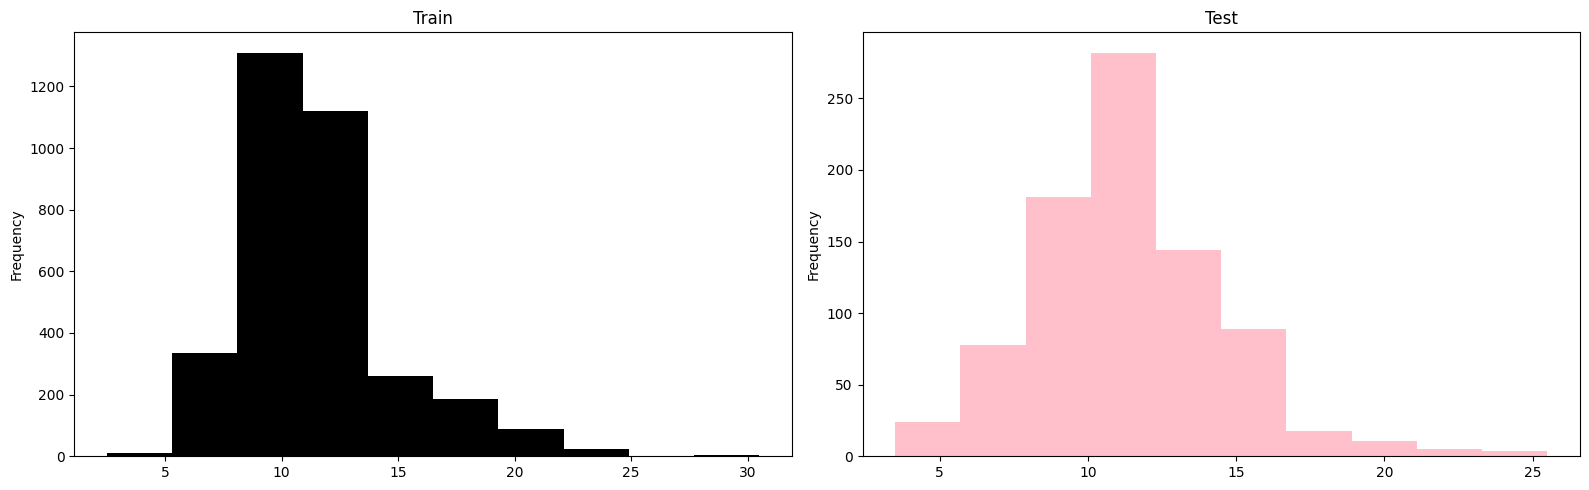

In [72]:
fig, axes = plt.subplots(ncols=2,figsize=(16, 5))

tCopy[target].plot.hist(color='black', ax=axes[0])
axes[0].set(title="Train")

test[target].plot.hist(color='pink', ax=axes[1])
axes[1].set(title="Test")

plt.tight_layout()
plt.show()

## **Looking for Feature Distribution**

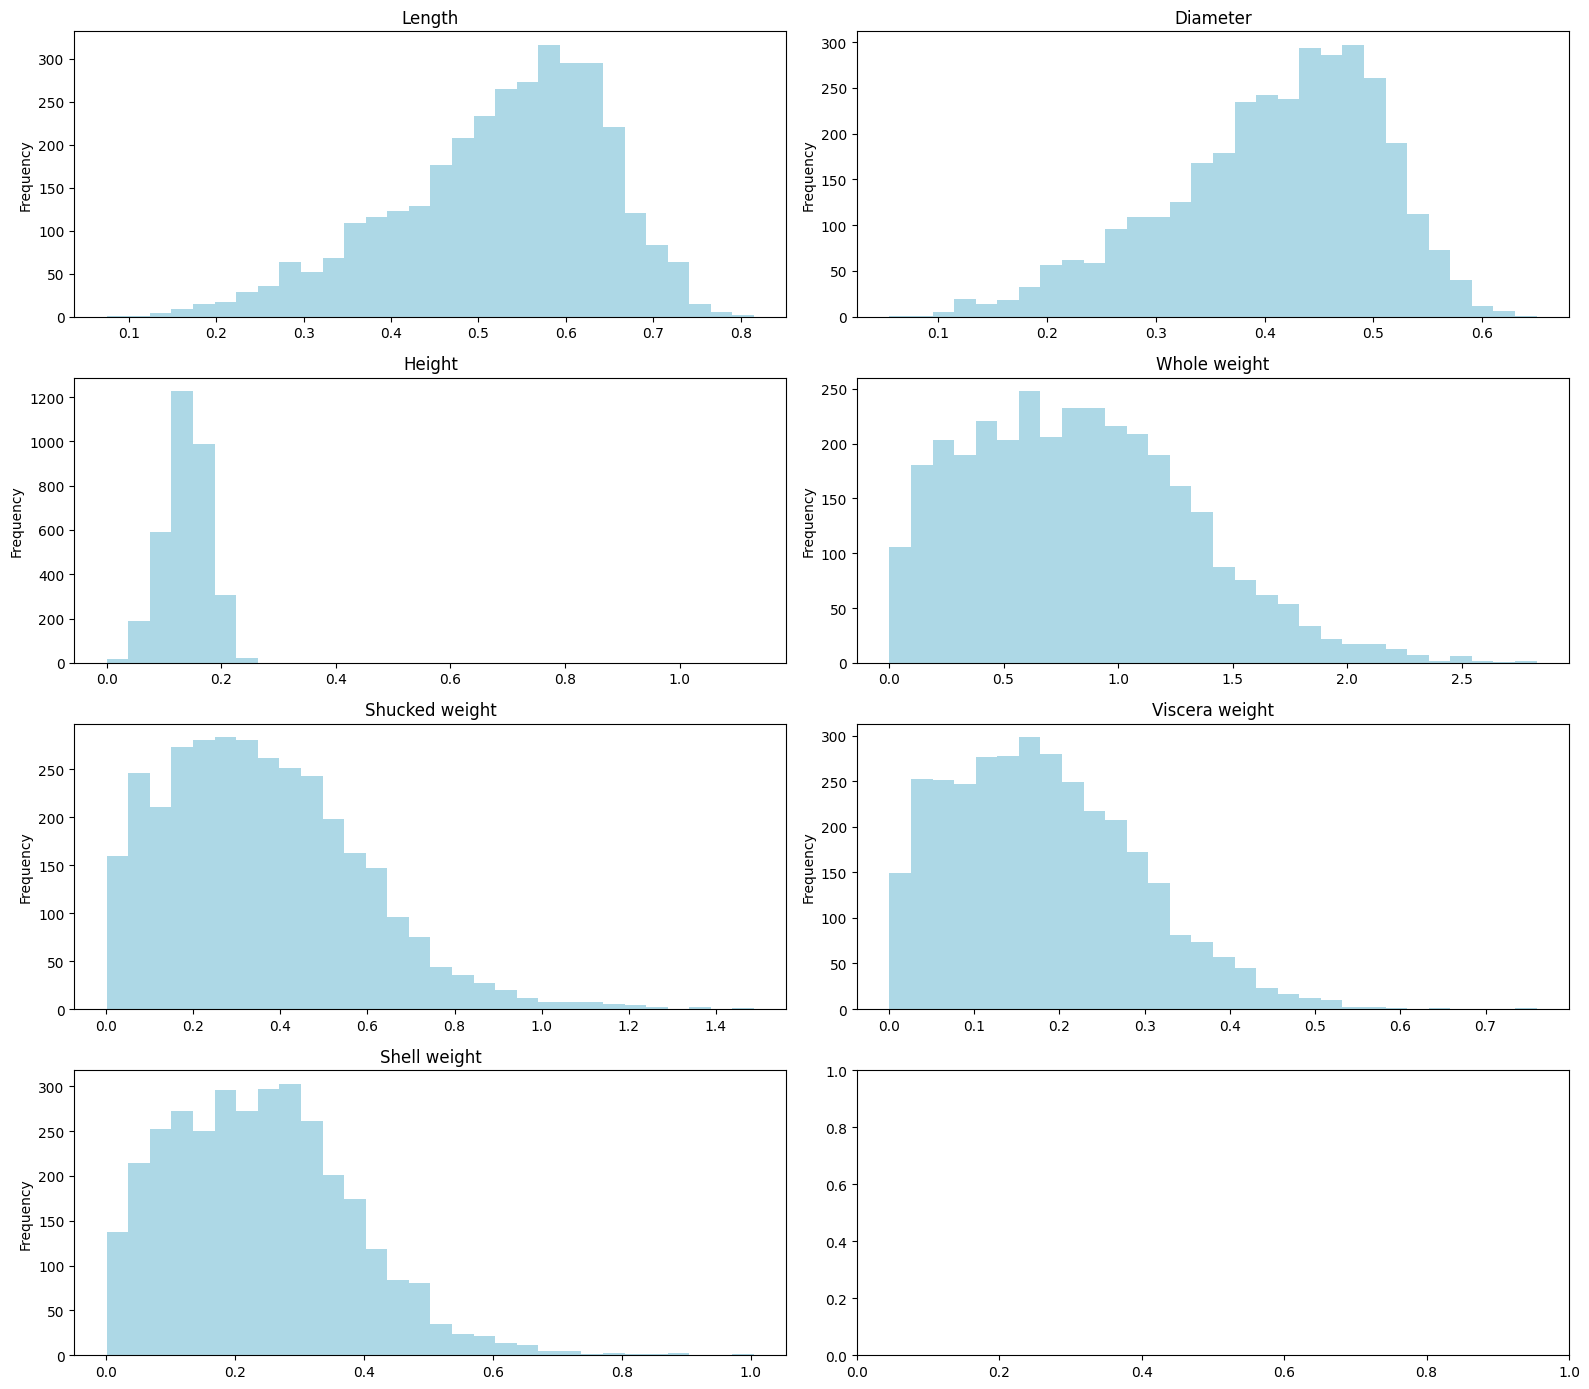

In [73]:
fig, axes = plt.subplots(4,2,figsize=(16, 14))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    hist = tCopy[c].plot(kind = 'hist', ax=axes[i], title=c, color='lightblue', bins=30)

plt.tight_layout()
plt.show()

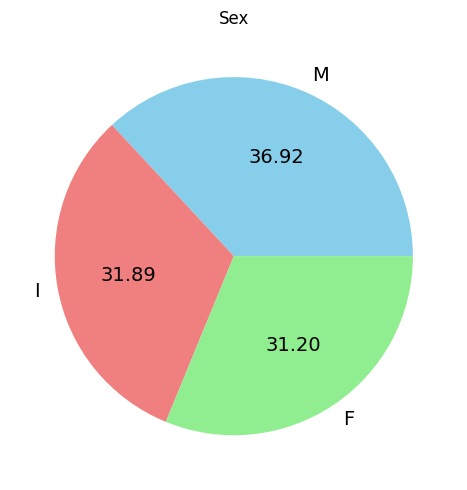

In [74]:
t = tCopy[categorical_feature].value_counts(normalize=True)
t.plot(kind='pie',
       figsize=(5,5),
       title=categorical_feature,
       ylabel="",
       autopct="%.2f",
       fontsize=14,
       colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.tight_layout()
plt.show()

## **Looking for Missing Values**

we can see whether there are missing values or not with heatmap.

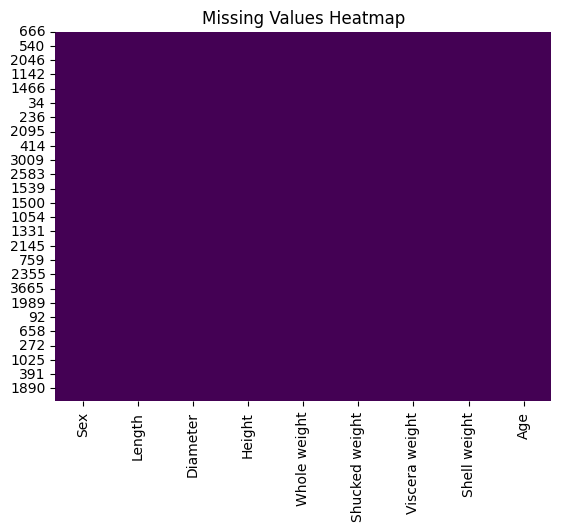

In [75]:
plt.figszie=(10,6)
sns.heatmap(tCopy.isnull(),cbar=False,cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

As we all knew, there are no missing values in the dataset as shown in the heatmap.

## **Looking for Outliers**

Next, we will indentify any outliers of age values.

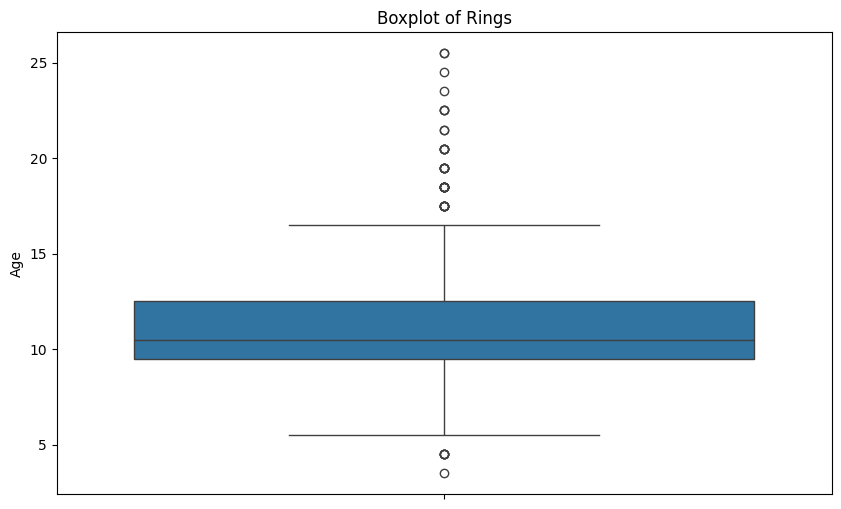

In [76]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Age', data=test)
plt.title('Boxplot of Rings')
plt.show()

Based on the box plot, there are some outliers present in the target variable, particularly on the higher end of the distribution. these outliers could potentially affect the performance of certain machine learning models that are sensitive to outliers. We will handle this later.

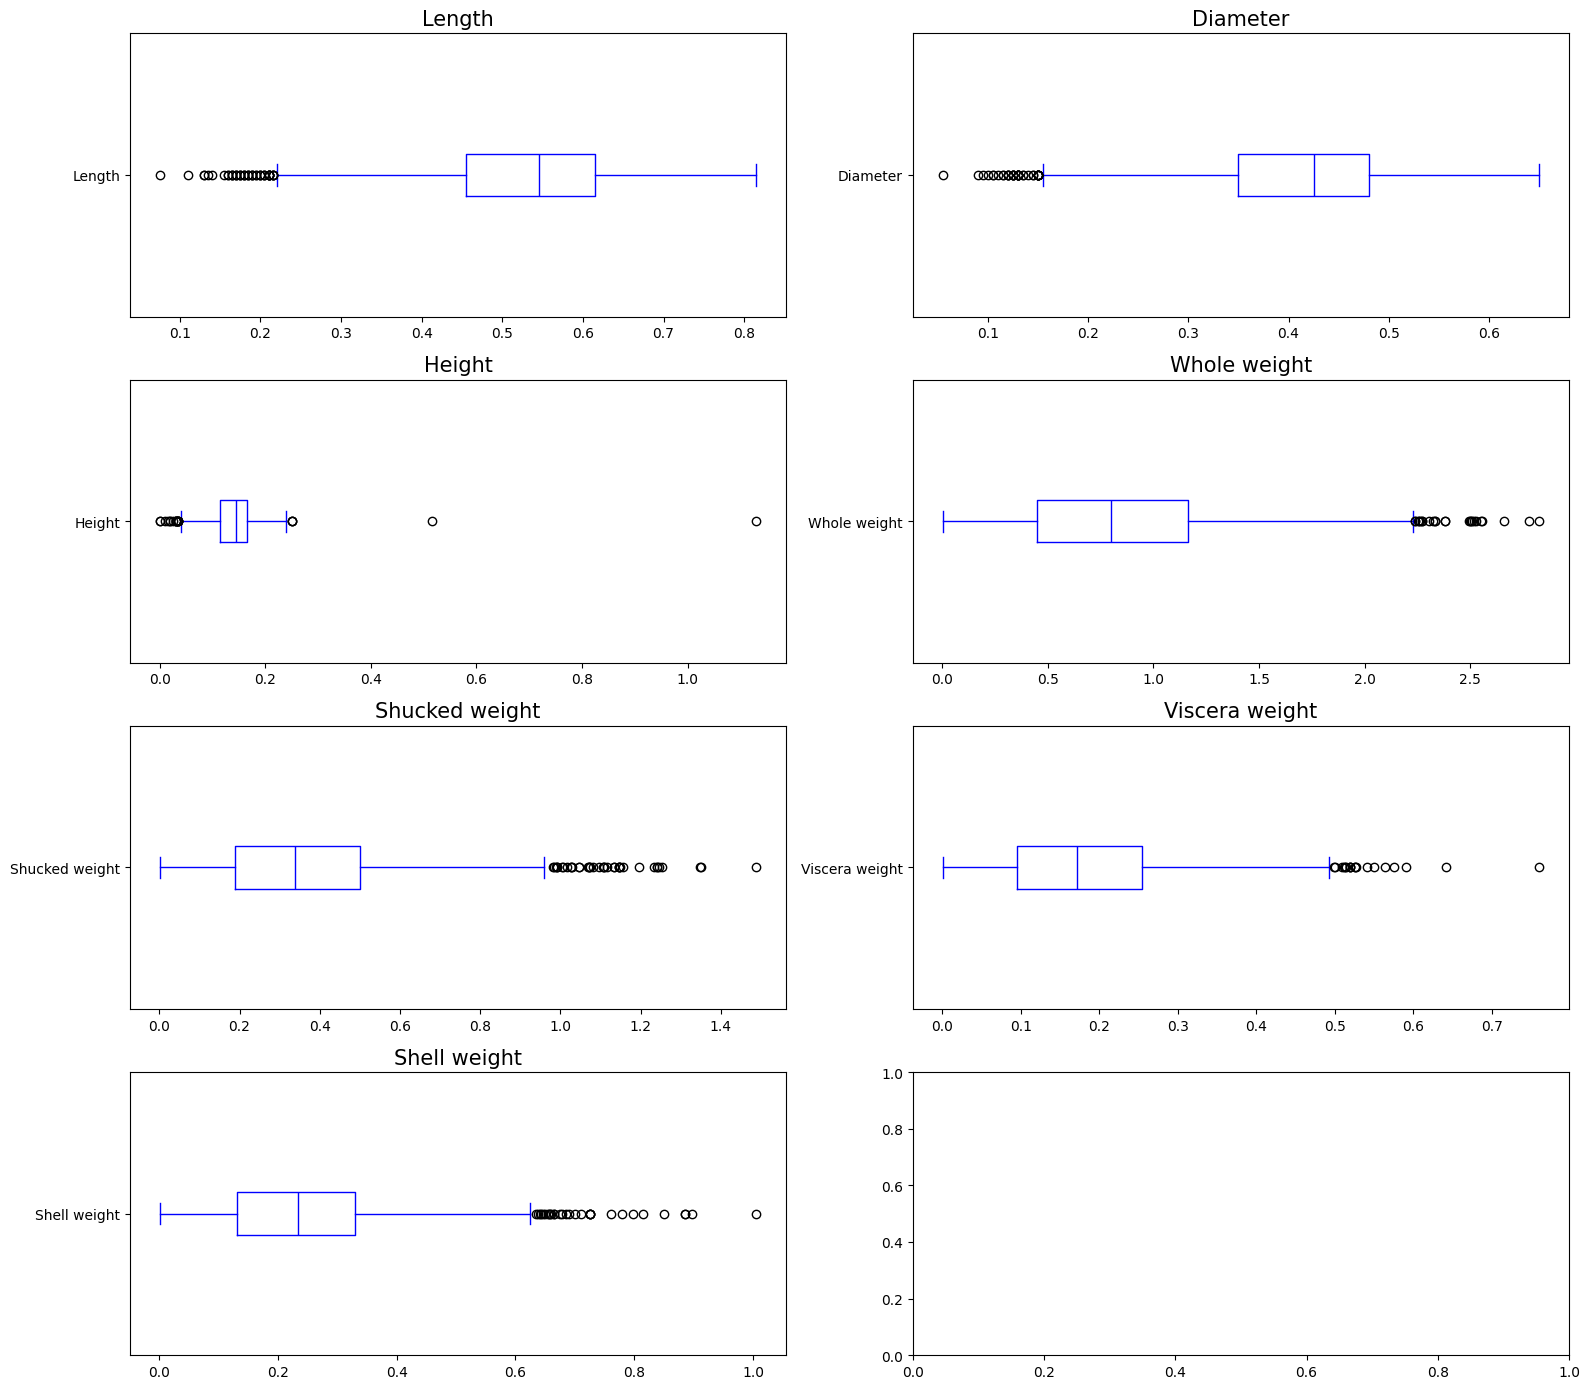

In [77]:
fig, axes = plt.subplots(4,2,figsize=(16, 14))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    hist = tCopy[c].plot(kind = 'box', ax=axes[i],color='blue', vert=False)
    axes[i].set_title(c, fontsize=15)

plt.tight_layout()
plt.show()

## **Looking for correlations**

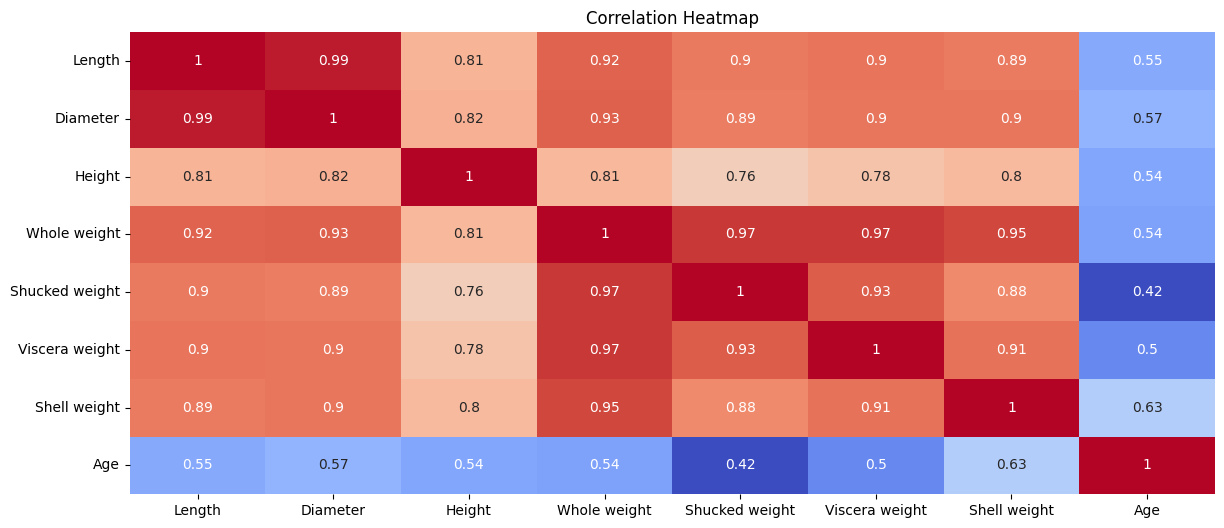

In [78]:
plt.figure(figsize=(14,6))
sns.heatmap(tCopy.drop('Sex', axis=1).corr(method='pearson'),
            annot=True,
            cbar=False,
            cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **Looking for relation with "Age"**

We will use a scatter plot to see the relation with the target column

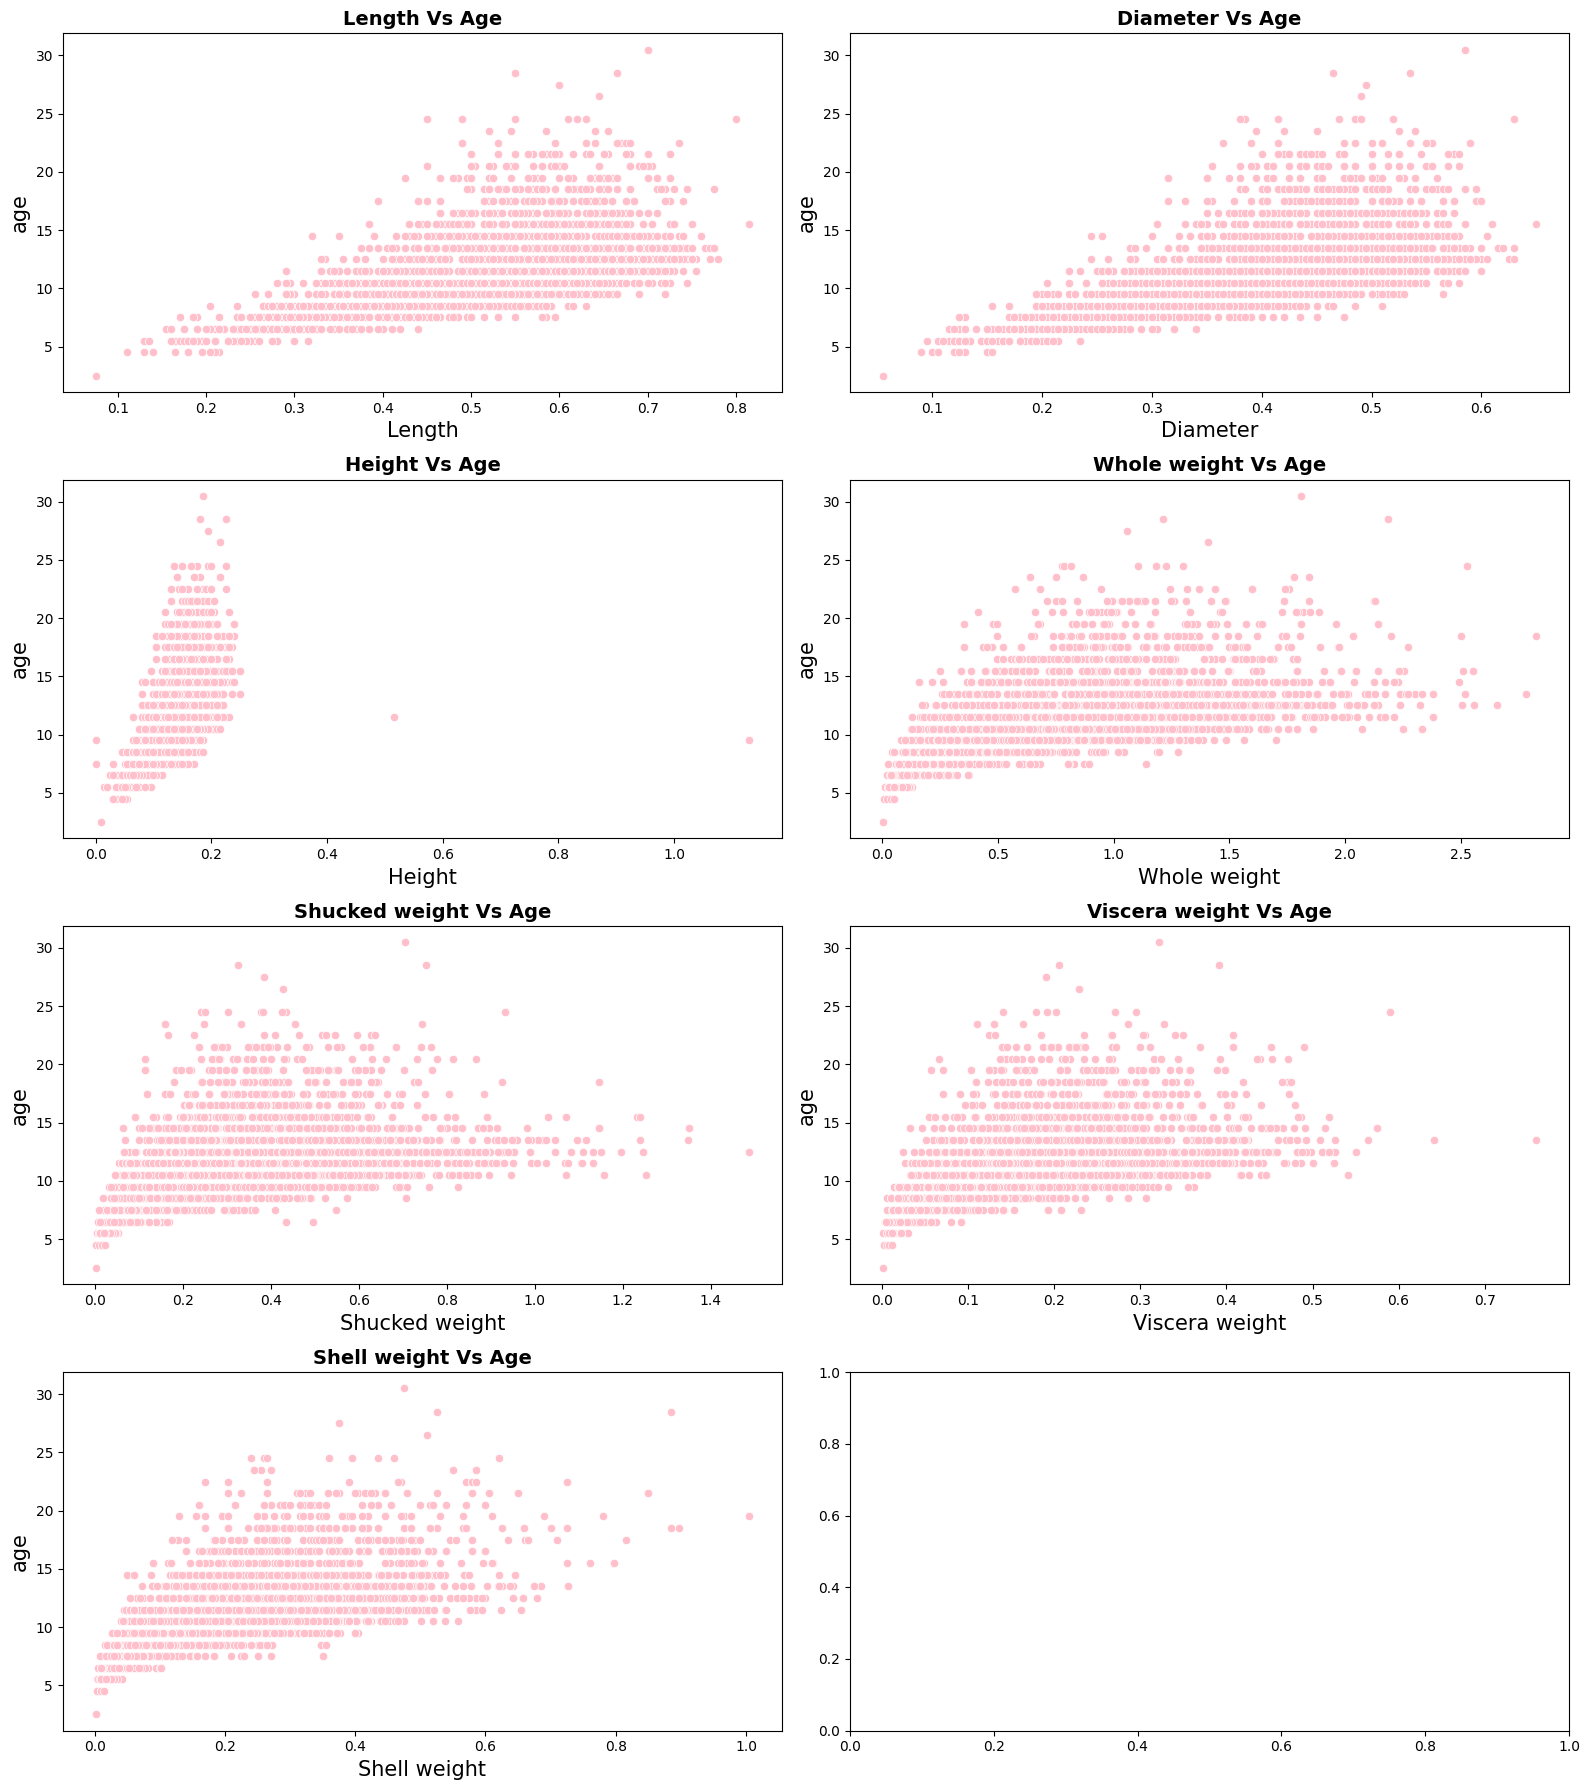

In [79]:
fig, axes = plt.subplots(4,2,figsize=(16, 18))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    _ = sns.scatterplot(x=train[c],
                        y=train[target],
                        ax=axes[i],
                        color='pink')

    axes[i].set_title(f"{c} Vs Age",
                      fontsize=14,
                      fontweight='bold')

    axes[i].set_xlabel(c, fontsize=15)
    axes[i].set_ylabel('age', fontsize=15)

plt.tight_layout()
plt.show()

## **Observastion of Height Vs Length Vs Age**

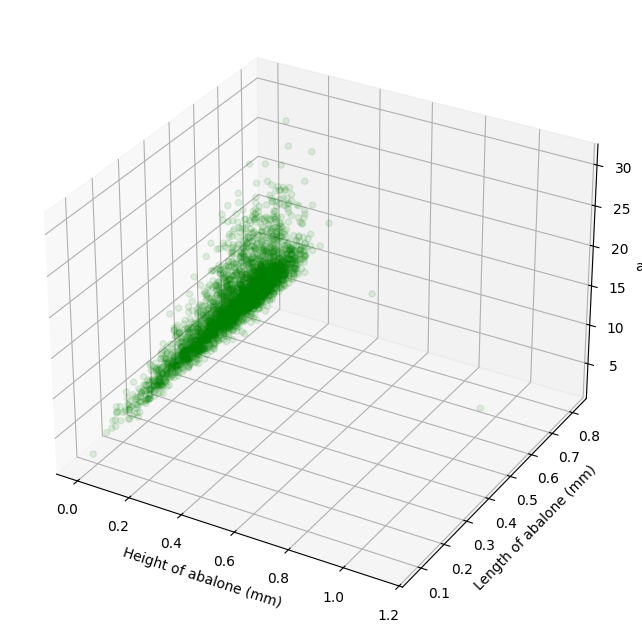

In [80]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.set_xlabel('Height of abalone (mm)')
ax.set_ylabel('Length of abalone (mm)')
ax.set_zlabel('age')
ax.scatter3D(train['Height'],
             train['Length'],
             train[target],
             c='green',
             alpha=0.1);

plt.show()

# **Prepare the Data for Machine Learning Algorithms**

## **Feature Engineering**

In [81]:
train.Sex = train.Sex.replace({"M":1, "I":0, "F":-1})
test.Sex = test.Sex.replace({"M":1, "I":0, "F":-1})

<ipython-input-81-63fd3d2cadc3>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.Sex = train.Sex.replace({"M":1, "I":0, "F":-1})
<ipython-input-81-63fd3d2cadc3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.Sex = test.Sex.replace({"M":1, "I":0, "F":-1})


## **Data Cleaning**

Based on the observation, we shall now clean outliers in feature columns(Height and Viscera Weight) and the target column.

In [82]:
idx = train.loc[train.Height>0.4].index
train.drop(idx, inplace=True)

idx = train.loc[train['Viscera weight']>0.6].index
train.drop(idx, inplace=True)

idx = train.loc[train[target]>25].index
train.drop(idx, inplace=True)

Then, we shall prepare the data for training now.

In [83]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex
666,0.485,0.380,0.150,0.6050,0.2155,0.1400,0.180,-1
2812,0.255,0.195,0.055,0.0725,0.0285,0.0170,0.021,0
1862,0.520,0.415,0.140,0.6375,0.3080,0.1335,0.168,0
3682,0.620,0.525,0.155,1.0850,0.4540,0.1965,0.350,1
551,0.560,0.440,0.165,0.8000,0.3350,0.1735,0.250,0


# **Select and Train the model**

In [84]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

**Linear Regression**

In [85]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

**Decision Tree**

In [86]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

**Random Forest**

In [87]:
rf_model= RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [88]:
print("lr_model train rmse :", rmse(y_train, lr_model.predict(X_train)))
print("dt_model train rmse :", rmse(y_train, dt_model.predict(X_train)))
print("rf_model train rmse :", rmse(y_train, rf_model.predict(X_train)))

lr_model train rmse : 2.193407363882639
dt_model train rmse : 0.0
rf_model train rmse : 0.794966792099128


# **Evaluation**

In [89]:
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = rmse(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr}")

Linear Regression RMSE: 2.081121832600188


In [90]:
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
rmse_dt = rmse(y_test, y_pred_dt)
print(f"Decision Tree RMSE: {rmse_dt}")

Decision Tree RMSE: 3.0899590434101474


In [91]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = rmse(y_test, y_pred_rf)
print(f"KNN RMSE: {rmse_rf}")

KNN RMSE: 2.070044668172565


# **Fine-Tuning**

**Decision Tree**

In [92]:
dt_params =  {'max_depth': [4, 6, 8, 10, 12, 14, 16, 20],
            'min_samples_split': [5, 10, 20, 30, 40, 50],
            'max_features': [0.2, 0.4, 0.6, 0.8, 1],
            'max_leaf_nodes': [8, 16, 32, 64, 128,256]}

dt_search = RandomizedSearchCV(dt_model, dt_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
dt_search.fit(X_train, y_train)

print(f"Best Decision Tree Parameters: {dt_search.best_params_}")
print(f"Best Decision Tree RMSE: {-dt_search.best_score_}")

Best Decision Tree Parameters: {'min_samples_split': 20, 'max_leaf_nodes': 32, 'max_features': 0.4, 'max_depth': 16}
Best Decision Tree RMSE: 2.3893695777457826


**Random Forest**

In [93]:
rf_params = {'bootstrap': [True, False],
             'max_depth': [2, 5, 10, 20, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100, 150, 200, 250]}

rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=20, cv=7, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

print(f"Best Random Forest Parameters: {rf_search.best_params_}")
print(f"Best Random Forest RMSE: {-rf_search.best_score_}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
56 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Random Forest Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best Random Forest RMSE: 2.1246006497331194


# **Final Training and Evaluation**

**Decision Tree**

In [94]:
dt_params =  {'max_depth': 16,
            'min_samples_split': 20,
            'max_features': 0.4,
            'max_leaf_nodes': 32}

dt_model = DecisionTreeRegressor(random_state=1, **dt_params)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=16, max_features=0.4, max_leaf_nodes=32,
                      min_samples_split=20, random_state=1)

**Random Forest**

In [95]:
rf_params = {'n_estimators': 250,
             'min_samples_split': 5,
             'min_samples_leaf': 1,
             'max_features': 'sqrt',
             'max_depth': 20,
             'bootstrap': True}

rf_model = RandomForestRegressor(random_state=1, **rf_params)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=250, random_state=1)

In [96]:
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance
rmse_dt = rmse(y_test, y_pred_dt)
print(f"Decision Tree RMSE: {rmse_dt}")

Decision Tree RMSE: 2.212262862860583


In [97]:
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = rmse(y_test, y_pred_rf)
print(f"KNN RMSE: {rmse_rf}")

KNN RMSE: 2.0145094569540873


**A comparsion of models' performance**

In [98]:
accuracy_lr=r2_score(y_test, y_pred_lr)
accuracy_dt=r2_score(y_test, y_pred_dt)
accuracy_rf=r2_score(y_test, y_pred_rf)

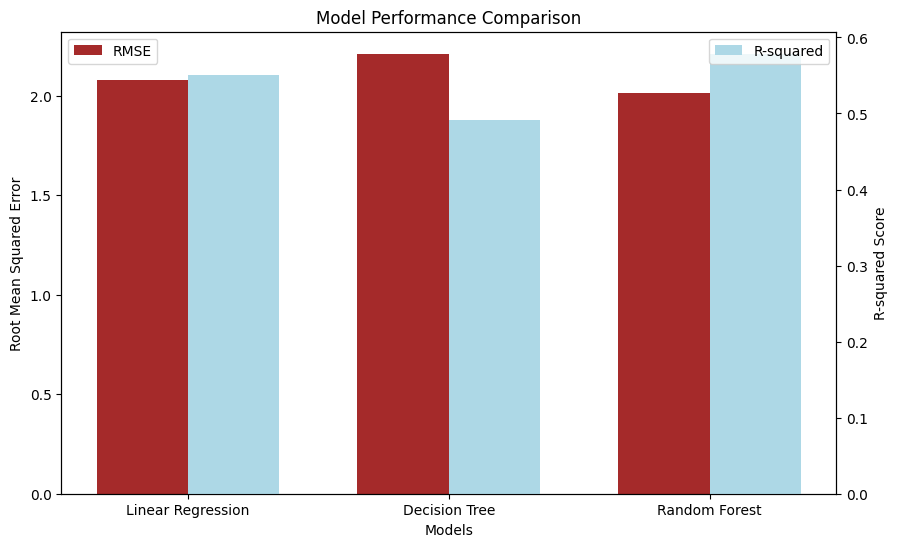

In [99]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
rmse_values = [rmse_lr, rmse_dt, rmse_rf]
r2_values = [accuracy_lr, accuracy_dt, accuracy_rf]

#the positions and width for the bars
x = np.arange(len(models))
width = 0.35


fig, ax1 = plt.subplots(figsize=(10, 6))

bar1 = ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='brown')
ax1.set_xlabel('Models')
ax1.set_ylabel('Root Mean Squared Error')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')

#a secondary y-axis for the R-squared values
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2_values, width, label='R-squared', color='lightblue')
ax2.set_ylabel('R-squared Score')
ax2.legend(loc='upper right')

plt.show()

By comparing all the models, the Random Forest model performs the best in terms of both RMSE and R² score, making it the most suitable model among the three for predicting the age. The Linear Regression model also performs well, but not as well as Random Forest, while Decision Tree shows the least accurate predictions.


We can also see comparison of the actual and predicted values for all three models as well.

In [100]:
results_df = pd.DataFrame({
    'Actual Abalone Age': y_test,
    'Predicted Age (rf)': y_pred_rf,
    'Predicted Age (Decision Tree)': y_pred_dt,
    'Predicted Age (Linear Regression)': y_pred_lr,
    'Accuracy score(LR)': [accuracy_lr] * len(y_test),
    'Accuracy score(DT)': [accuracy_dt] * len(y_test),
    'Accuracy score(RF)': [accuracy_rf] * len(y_test)

})

results_df.head()

,Actual Abalone Age,Predicted Age (rf),Predicted Age (Decision Tree),Predicted Age (Linear Regression),Accuracy score(LR),Accuracy score(DT),Accuracy score(RF)
17,8.5,10.562113,10.171875,9.396650,0.550204,0.491731,0.578537
1131,10.5,11.797988,13.529412,12.218035,0.550204,0.491731,0.578537
299,10.5,10.387338,8.571429,9.172490,0.550204,0.491731,0.578537
1338,9.5,11.162747,11.878947,11.806130,0.550204,0.491731,0.578537
2383,12.5,11.087819,10.335979,10.389655,0.550204,0.491731,0.578537


We will now save the model for the deployment.

In [101]:
import pickle
with open("/content/drive/My Drive/ML PERSONAL/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)